In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

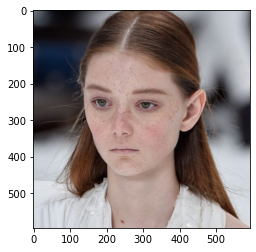

In [2]:
img = mpimg.imread('foreign.bmp')
plt.imshow(img)
plt.show()

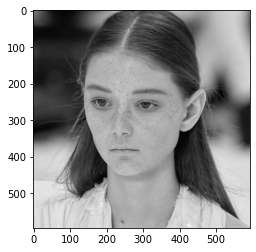

In [3]:
hlsImg = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
plt.imshow(hlsImg[:,:,1],cmap='gray')
plt.show()

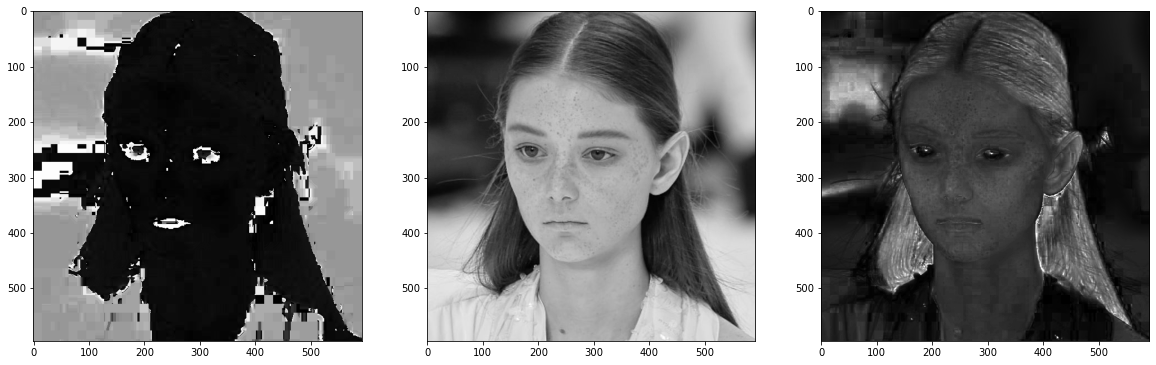

In [4]:
fig,ax=plt.subplots(nrows=1, ncols=3,figsize=(20,20))
ax[0].imshow(hlsImg[:,:,0],cmap='gray')
ax[1].imshow(hlsImg[:,:,1],cmap='gray')
ax[2].imshow(hlsImg[:,:,2],cmap='gray')
plt.show()

In [8]:
def img_filter(fil,img,padding='same',stride=1):
    if padding == 'same':
        pad_hei = int(((img.shape[0]-1)*stride+fil.shape[0]-img.shape[0])/2)
        new_hei = img.shape[0]+pad_hei*2
        pad_wid = int(((img.shape[1]-1)*stride+fil.shape[1]-img.shape[1])/2)
        new_wid = img.shape[1]+pad_wid*2
        fil_img = np.zeros((img.shape[0],img.shape[1]),dtype='uint8')
    '''if padding == 'valid':
    '''
    new_img = np.zeros((new_hei, new_wid),dtype='int')
    new_img[pad_hei:new_img.shape[0]-pad_hei,pad_wid:new_img.shape[1]-pad_wid] = img
    fil_hei, fil_wid = fil.shape
    for row in range(pad_hei, new_img.shape[0]-pad_hei):
        for col in range(pad_wid, new_img.shape[1]-pad_wid):
            new_pix = new_img[int(row-(fil_hei-1)/2):int(row+(fil_hei-1)/2)+1, int(col-(fil_wid-1)/2):int(col+(fil_wid-1)/2)+1]*fil
            fil_img[row-pad_hei,col-pad_wid] = abs(round(np.sum(new_pix)))
            
    return fil_img

In [5]:
def gaussian_noise(img, mean=0, sigma=0.1):
    
    img = img / 255.0
    noise = np.random.normal(mean, sigma, img.shape)
    gaussian_out = img + noise
    gaussian_out = np.clip(gaussian_out, 0, 1)
    
    gaussian_out = np.uint8(gaussian_out*255)
    noise = np.uint8(noise*255)
    
    #print("gaussian noise: ")
    #show_img(noise)
    
    #print("Picture add gaussian noise: ")
    return gaussian_out

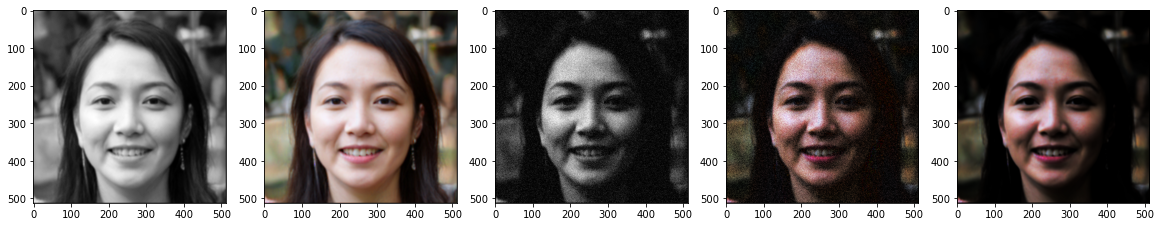

In [205]:
fig,ax=plt.subplots(nrows=1, ncols=5,figsize=(20,20))
avg = np.copy(hlsImg)
avg_fil = np.ones((5,5))
avg_fil = avg_fil/np.sum(avg_fil)
avg_tem = img_filter(avg_fil,avg[:,:,1])
avg[:,:,1] = avg_tem
avg_img = cv2.cvtColor(avg, cv2.COLOR_HLS2RGB)


dark = np.copy(hlsImg)
dark_tem = power_law_transform(avg_tem,3,c=1)
dark[:,:,1] = dark_tem
dark_Img = cv2.cvtColor(dark, cv2.COLOR_HLS2RGB)

gau_avg = np.copy(hlsImg)
gau_avg_tem = gaussian_noise(dark_tem, mean=0, sigma=0.1)
gau_avg[:,:,1] = gau_avg_tem
gau_avg_img = cv2.cvtColor(gau_avg, cv2.COLOR_HLS2RGB)


ax[0].imshow(avg_tem,cmap='gray')
ax[1].imshow(avg_img)
ax[2].imshow(gau_avg_tem,cmap='gray')
ax[3].imshow(gau_avg_img)
ax[4].imshow(dark_Img)
plt.show()

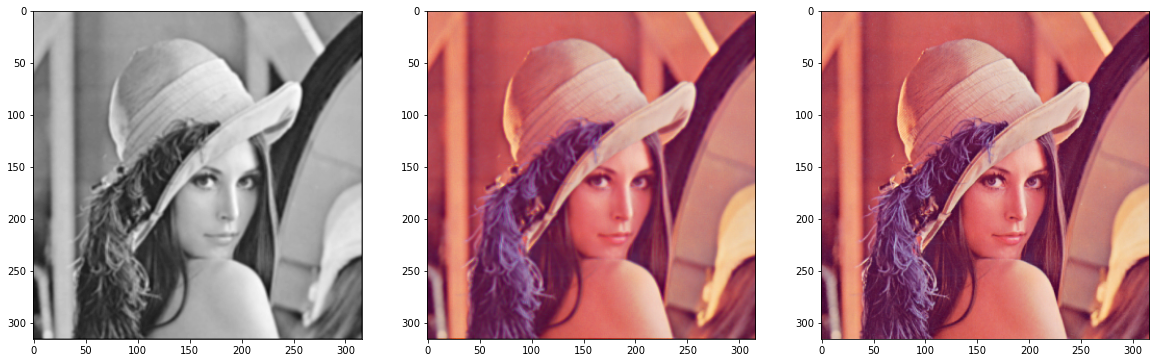

In [6]:
def bilateral_filter(gau_fil,img,sigma_c,padding='same',stride=1):
    fil_siz = gau_fil.shape[0]
    if padding == 'same':
        pad_hei = int(((img.shape[0]-1)*stride+fil_siz-img.shape[0])/2)
        new_hei = img.shape[0]+pad_hei*2
        pad_wid = int(((img.shape[1]-1)*stride+fil_siz-img.shape[1])/2)
        new_wid = img.shape[1]+pad_wid*2
        fil_img = np.zeros((img.shape[0],img.shape[1]),dtype='uint8')

    new_img = np.zeros((new_hei, new_wid),dtype='int')
    new_img[pad_hei:new_img.shape[0]-pad_hei,pad_wid:new_img.shape[1]-pad_wid] = img

    for row in range(pad_hei, new_img.shape[0]-pad_hei):
        for col in range(pad_wid, new_img.shape[1]-pad_wid):
            patch = new_img[int(row-(fil_siz-1)/2):int(row+(fil_siz-1)/2)+1, int(col-(fil_siz-1)/2):int(col+(fil_siz-1)/2)+1]
            fea_pre = np.exp((abs(patch - new_img[row,col])/255)*(-1)/(2*np.square(sigma_c)))
            new_pix = patch*fea_pre*gau_fil
            nor_pix = new_pix/np.sum(fea_pre*gau_fil)
            fil_img[row-pad_hei,col-pad_wid] = round(np.sum(nor_pix))
            #new_pix = (patch*gau_fil)/np.sum(gau_fil)
            #fil_img[row-pad_hei,col-pad_wid] = round(np.sum(new_pix))

    return fil_img

fil_siz = 3
gau_fil = np.ones((fil_siz,fil_siz))
x_cor = int((fil_siz-1)/2)
y_cor = int((fil_siz-1)/2)
for y in range(-y_cor,y_cor+1):
    for x in range(-x_cor,x_cor+1):
        gau_fil[y+y_cor,x+x_cor] = np.exp(-(x**2+y**2)/(2*np.square(36)))
        

fig,ax=plt.subplots(nrows=1, ncols=3,figsize=(20,20))
h = np.copy(hlsImg)
c = bilateral_filter(gau_fil,h[:,:,1],36)
ax[0].imshow(c,cmap='gray')
h[:,:,1] = c
z = cv2.cvtColor(h, cv2.COLOR_HLS2RGB)
ax[1].imshow(z)
ax[2].imshow(img)
plt.show()

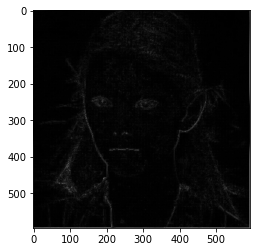

In [9]:
test2 = np.copy(img).astype('int')
lap_fil_3=np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
fil_img = img_filter(lap_fil_3,test2[:,:,1])
#test2[:,:,1] = test2[:,:,1] + 0.5 * fil_img
#test2[:,:,1][test2[:,:,1]>255]=255
#test2 = test2.astype('uint8')
#Img2 = cv2.cvtColor(test2, cv2.COLOR_HLS2RGB)
plt.imshow(fil_img,cmap='gray')
plt.show()

In [6]:
def beauty_face(img):

    dst = np.zeros_like(img)
    v1 = 5
    v2 = 2
    dx = v1 * 5 
    fc = v1 * 12.5
    p = 0.1
   
    temp4 = np.zeros_like(img)
    
    temp1 = cv2.bilateralFilter(img,dx,fc,fc)
    temp2 = cv2.subtract(temp1,img)
    temp2 = cv2.add(temp2,(10,10,10,128))
    temp3 = cv2.GaussianBlur(temp2,(2*v2 - 1,2*v2-1),0)
    temp4 = cv2.add(img,temp3)
    dst = cv2.addWeighted(img,p,temp4,1-p,0.0)
    dst = cv2.add(dst,(10, 10, 10,255))
    return dst

def beauty_face2(src):

    dst = np.zeros_like(src)
    v1 = 5
    v2 = 2
    dx = v1 * 5
    fc = v1 * 12.5
    p = 0.1
   
    temp4 = np.zeros_like(src)
    
    temp1 = cv2.bilateralFilter(src,dx,fc,fc)
    temp2 = cv2.subtract(temp1,src)
    temp2 = cv2.add(temp2, (10,10,10,128))
    temp3 = cv2.GaussianBlur(temp2,(2*v2 - 1,2*v2-1),0)
    temp4 = cv2.subtract(cv2.add(cv2.add(temp3, temp3), src), (10, 10, 10, 255))
    
    dst = cv2.addWeighted(src,p,temp4,1-p,0.0)
    dst = cv2.add(dst, (10, 10, 10,255))
    return dst

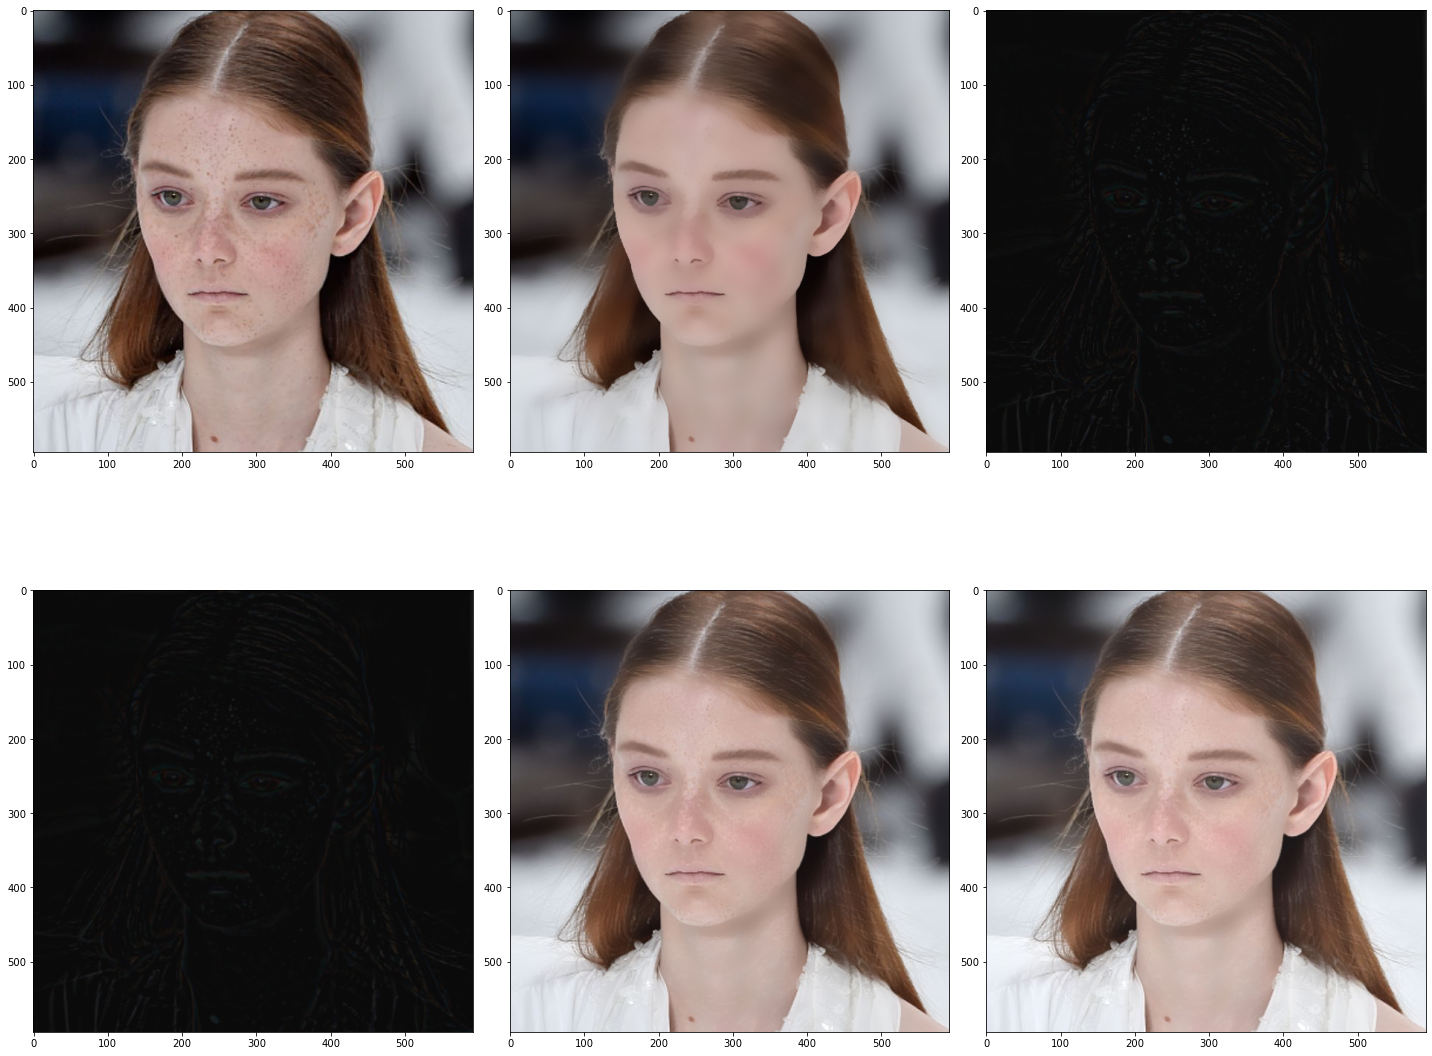

In [208]:
fig,ax=plt.subplots(nrows=2, ncols=3,figsize=(20,20))
dst,temp1,temp2,temp3,temp4 = beauty_face(img)
ax[0,0].imshow(img)
ax[0,1].imshow(temp1)
ax[0,2].imshow(temp2,cmap='gray')
fig.tight_layout()
ax[1,0].imshow(temp3,cmap='gray')
ax[1,1].imshow(temp4)
ax[1,2].imshow(dst)
fig.tight_layout()
plt.show()

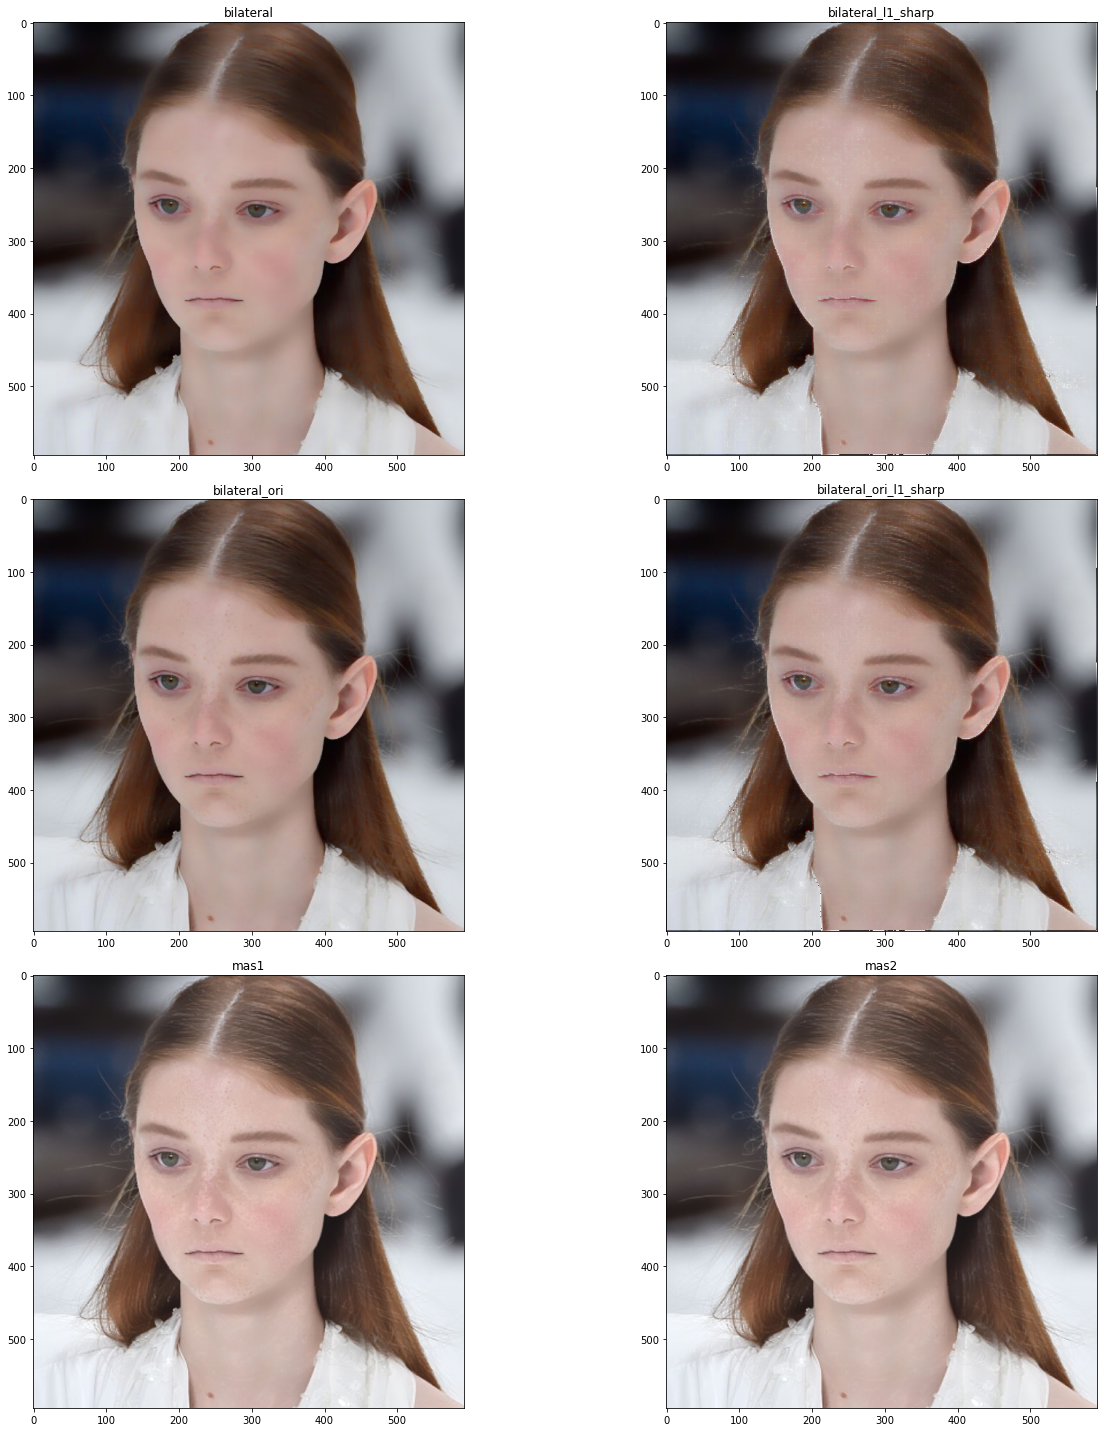

In [10]:
#img = ga_Img
fig,ax=plt.subplots(nrows=3, ncols=2,figsize=(20,20))
h = np.copy(hlsImg)
g = np.copy(hlsImg)
c = cv2.bilateralFilter(h[:,:,1], 25, 25, 25)
#ax[0].imshow(c,cmap='gray')
h[:,:,1] = c
z = cv2.cvtColor(h, cv2.COLOR_HLS2RGB)
w = cv2.addWeighted(img, 0.3, z, 0.7, 0)
p = cv2.cvtColor(w, cv2.COLOR_RGB2HLS)
p[:,:,1] = p[:,:,1] + 0.5 * fil_img
p2 = cv2.cvtColor(p, cv2.COLOR_HLS2RGB
                 )
g[:,:,1] = c + 0.5 * fil_img
j = cv2.cvtColor(g, cv2.COLOR_HLS2RGB)

mas1 = beauty_face(img)
mas2 = beauty_face(img)
ax[0,0].imshow(z)
ax[0,0].set_title('bilateral')
ax[0,1].imshow(j)
ax[0,1].set_title('bilateral_l1_sharp')
ax[1,0].imshow(w)
ax[1,0].set_title('bilateral_ori')
ax[1,1].imshow(p2)
ax[1,1].set_title('bilateral_ori_l1_sharp')
ax[2,0].imshow(mas1)
ax[2,0].set_title('mas1')
ax[2,1].imshow(mas2)
ax[2,1].set_title('mas2')

#ax[4].imshow(img)
fig.tight_layout()
plt.show()


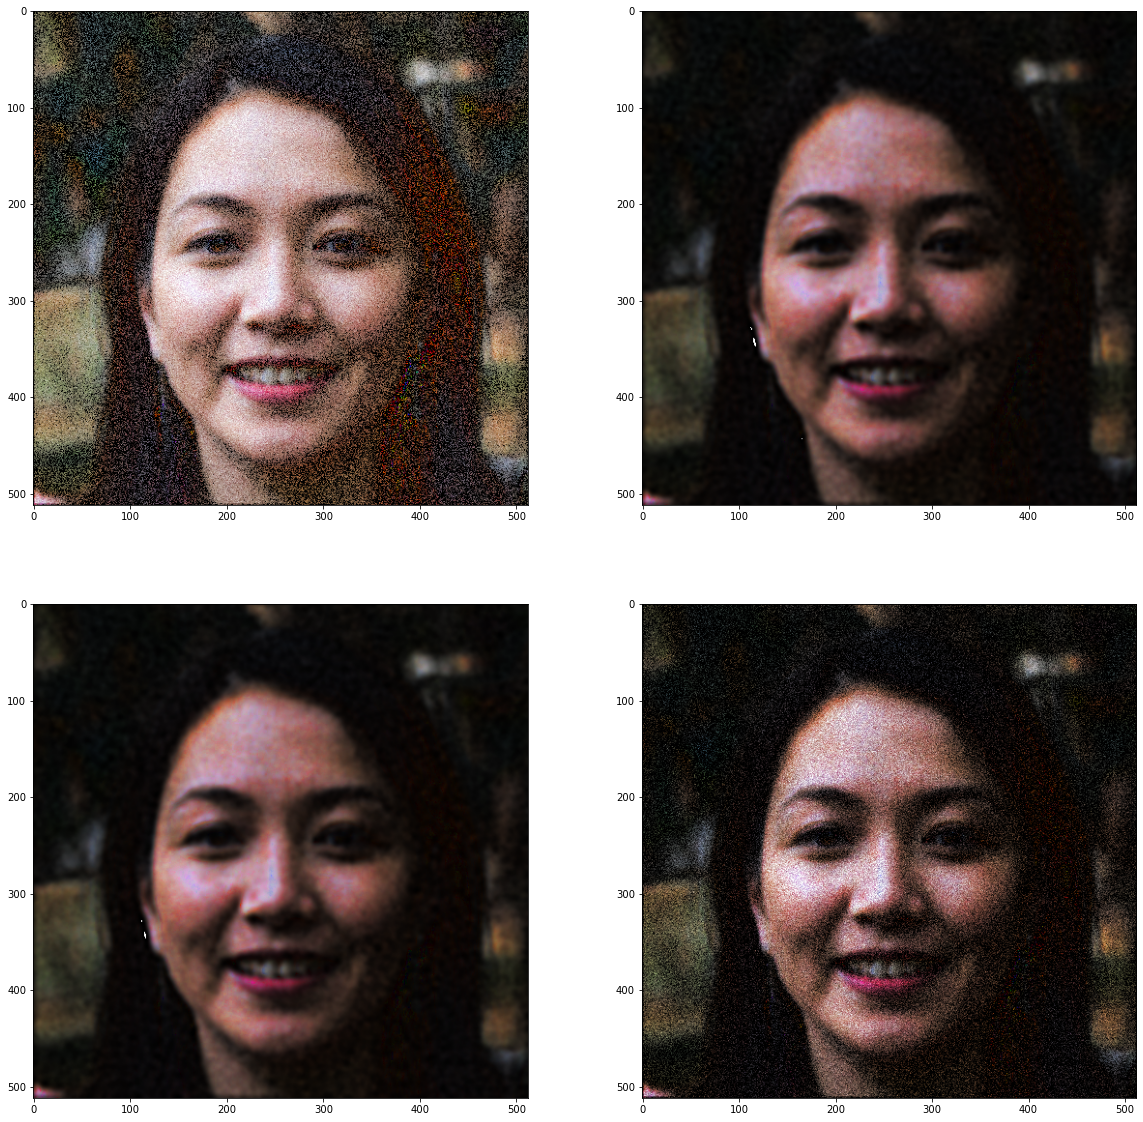

In [220]:
def dct_wiener_filter(img, kernel, K):
    #kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.float32(dummy)
    dummy = cv2.dct(dummy)
    #kernel = np.fft.fft2(kernel, s = img.shape)
    new_kernel = 1.3*kernel / (np.abs(kernel) ** 2+0.5)
    reg_r = int(img.shape[0]/2)
    reg_c = int(img.shape[1]/2)
    #new_kernel[reg_r:,reg_c:] = kernel[reg_r:,reg_c:] / (np.abs(kernel[reg_r:,reg_c:]) ** 2 + K)
    dummy = dummy * (new_kernel)
    dummy = cv2.idct(dummy)
    return dummy

def half_gaussion_lowpass(row,col,sigma):
    H = np.zeros((row,col))
    U0 = 0
    V0 = 0
    for u in range(row):
        for v in range(col):
            H[u,v] = math.exp(-((u-U0)**2 + (v-V0)**2)/(2*np.power(sigma,2)))
    return H

def butterworth_lowpass(row,col,D0,n):
    H = np.zeros((row,col))
    U0 = 0
    V0 = 0
    for u in range(row):
        for v in range(col):
            dis = np.sqrt((u-U0)**2 + (v-V0)**2)
            H[u,v] =1/(1+np.power((dis/D0),2*n))
    return H

fig,ax=plt.subplots(nrows=2, ncols=2,figsize=(20,20))
gau_deb = np.copy(gau_avg)
but_deb = np.copy(gau_avg)
#h = cv2.cvtColor(b, cv2.COLOR_RGB2HLS)
gau_deb_tem = dct_wiener_filter(gau_deb[:,:,1], half_gaussion_lowpass(gau_deb.shape[0],gau_deb.shape[1],60),10)
but_deb_tem = dct_wiener_filter(but_deb[:,:,1], butterworth_lowpass(but_deb.shape[0],but_deb.shape[1],70,2),10)
ax[0,0].imshow(ga_Img)
#ax[1].imshow(half_gaussion_lowpass(deb.shape[0],deb.shape[1],120),cmap='gray')
gau_deb[:,:,1] = gau_deb_tem
but_deb[:,:,1] = but_deb_tem
gau_deb_img = cv2.cvtColor(gau_deb, cv2.COLOR_HLS2RGB)
but_deb_img = cv2.cvtColor(but_deb, cv2.COLOR_HLS2RGB)
ax[0,1].imshow(gau_deb_img)
ax[1,0].imshow(but_deb_img)
ax[1,1].imshow(gau_avg_img)
plt.show()

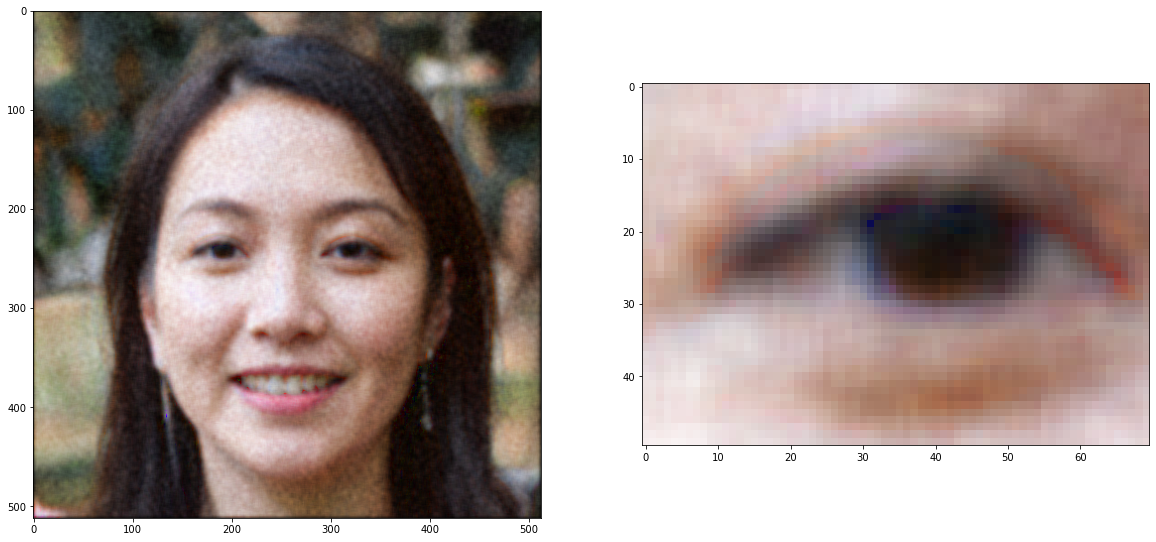

In [157]:
fig,ax=plt.subplots(nrows=1, ncols=2,figsize=(20,20))
pu_avg = np.copy(gau_avg)
avg_fil = np.ones((5,5))
avg_fil = avg_fil/np.sum(avg_fil)
pu_avg_tem = img_filter(avg_fil,pu_avg[:,:,1])
pu_avg[:,:,1] = pu_avg_tem
pu_avg_img = cv2.cvtColor(pu_avg, cv2.COLOR_HLS2RGB)
ax[0].imshow(pu_avg_img)
ax[1].imshow(pu_avg_img[220:270,150:220])
plt.show()

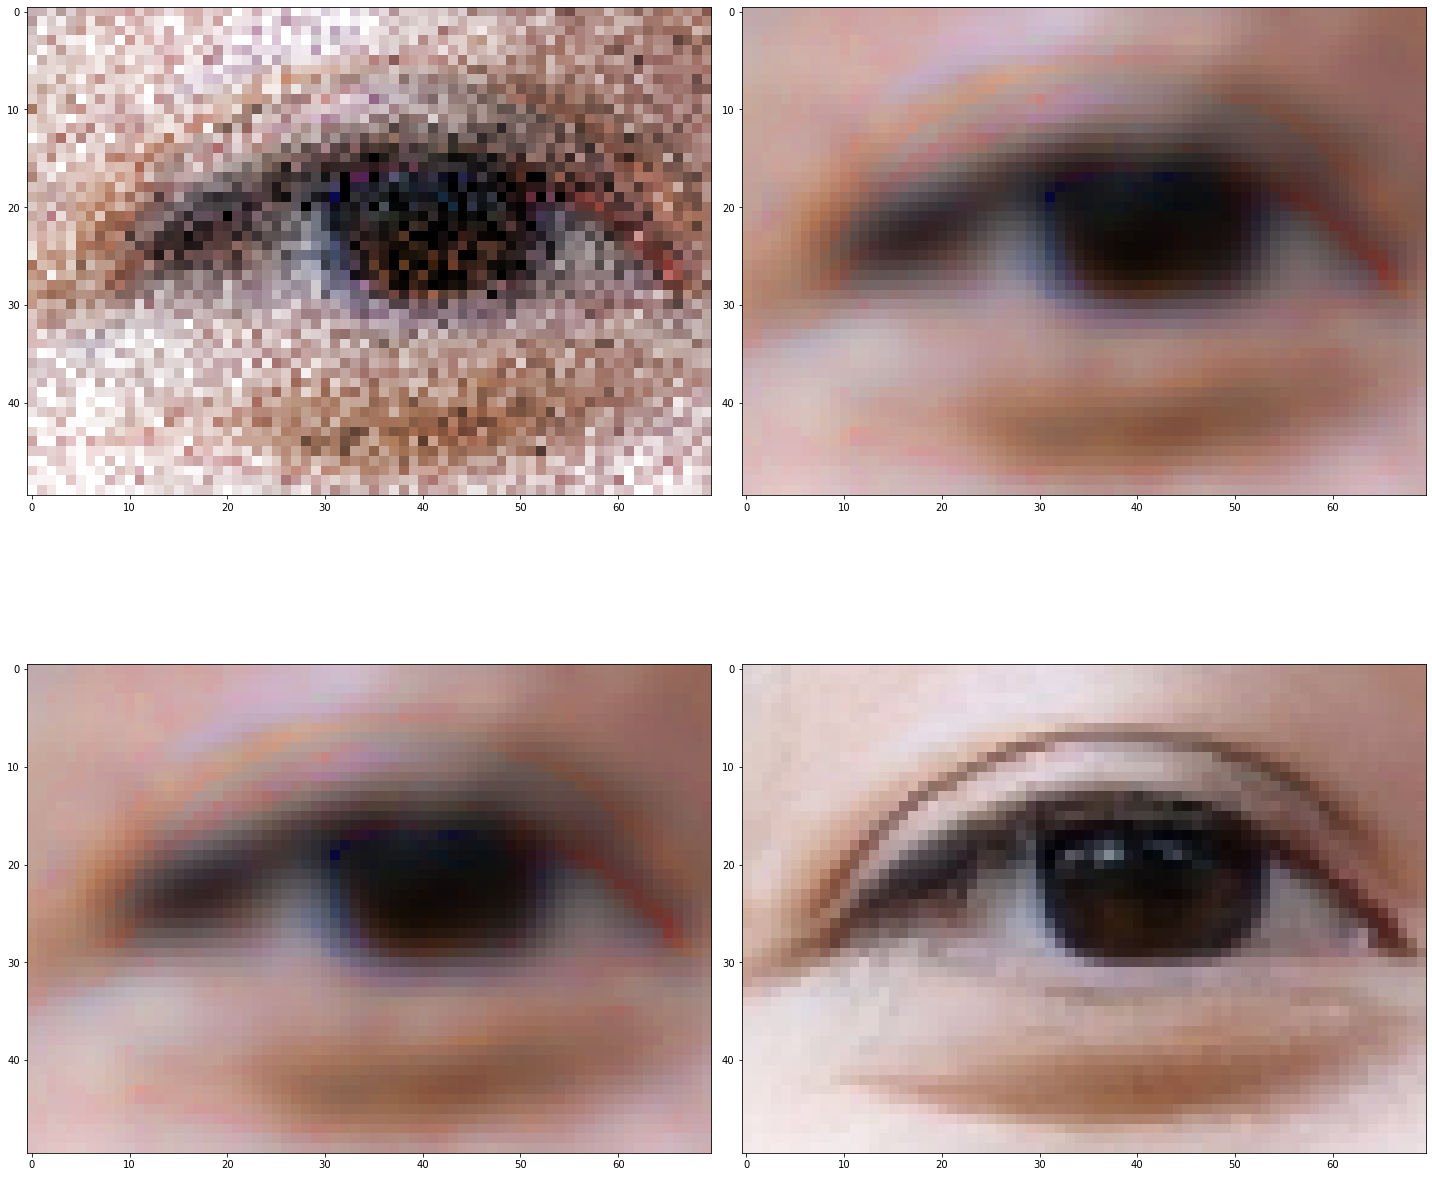

In [154]:
fig,ax=plt.subplots(nrows=2, ncols=2,figsize=(20,20))
ax[0,0].imshow(gau_avg_img[220:270,150:220])
ax[0,1].imshow(gau_deb_img[220:270,150:220])
ax[1,0].imshow(but_deb_img[220:270,150:220])
ax[1,1].imshow(img[220:270,150:220])
fig.tight_layout()
plt.show()

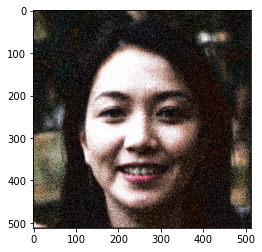

In [206]:
def log_transform(img,c=1):
    log_img = np.zeros((img.shape[0],img.shape[1]))
    log_img = c*255*np.log(1+img/255)
    log_img [log_img >255]=255
    log_img = log_img.astype('uint8')
        
    return log_img

hlsImg3 = np.copy(gau_avg)
#hlsImg3 = cv2.cvtColor(Img2, cv2.COLOR_RGB2HLS)        
log_img = log_transform(hlsImg3[:,:,1],c=2)
hlsImg3[:,:,1] = log_img
Img3 = cv2.cvtColor(hlsImg3, cv2.COLOR_HLS2RGB)
plt.imshow(Img3)
plt.show()

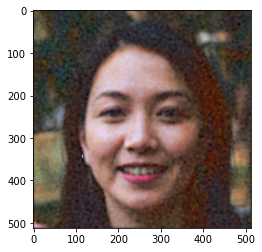

In [224]:
def power_law_transform(img,gamma,c=1):
    gamma_img = np.zeros((img.shape[0],img.shape[1]))
    gamma_img = c*255*((img/255)**gamma)
    gamma_img[gamma_img>255]=255
    gamma_img = gamma_img.astype('uint8')
        
    return gamma_img


#hlsImg = cv2.cvtColor(Img3, cv2.COLOR_RGB2HLS)
ga_img = np.copy(gau_deb)
ga_tem = power_law_transform(ga_img[:,:,1],0.5,c=1)
ga_img[:,:,1] = ga_tem
ga_Img = cv2.cvtColor(ga_img, cv2.COLOR_HLS2RGB)
plt.imshow(ga_Img)
plt.show()

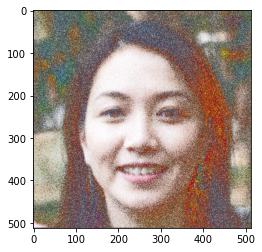

In [215]:
#histogram_equalization
def count_frequency(img):
    fla_img = img.flatten()
    nk=np.array([0]*256)
    for i in range(len(fla_img)):
        nk[fla_img[i]]+=1
    pk = nk/len(fla_img)
    return nk,pk

def histogram_equalization(ori_img):
    ROW = ori_img.shape[0]
    COL = ori_img.shape[1]
    ori_nk, ori_pk = count_frequency(ori_img)
    #cdf
    sk=[0]*256
    for i in range(len(sk)):
        sk[i]=round(255*(ori_pk[:i+1].sum()))
    #mapping
    trans = np.zeros((ROW,COL))
    for i in range(ROW):
        for j in range(COL):
            trans[i,j] = sk[ori_img[i,j]]
    trans[trans>255]=255
    trans = trans.astype('uint8')
    #equalization_pdf
    equ_nk, equ_pk = count_frequency(trans)
        
    #return trans,ori_pk,equ_pk
    return trans

his_equ = np.copy(gau_avg)
his_tem = histogram_equalization(his_equ[:,:,1])
his_equ[:,:,1] = his_tem
his_Img = cv2.cvtColor(his_equ, cv2.COLOR_HLS2RGB)
plt.imshow(his_Img)
plt.show()

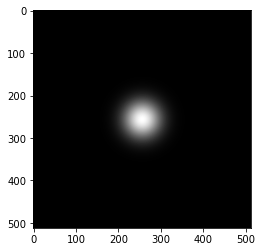

In [133]:
def ideal_lowpass(row,col,D0):
    H = np.zeros((row,col))
    U0 = row/2
    V0 = col/2
    #cut off
    for u in range(row):
        for v in range(col):
            dis = np.sqrt((u-U0)**2 + (v-V0)**2)
            
            if dis <= D0:
                H[u,v] = 1
            else:
                H[u,v] = 0
    return H

def gaussion_lowpass(row,col,sigma):
    H = np.zeros((row,col))
    U0 = row/2
    V0 = col/2
    for u in range(row):
        for v in range(col):
            H[u,v] = math.exp(-((u-U0)**2 + (v-V0)**2)/(2*np.power(sigma,2)))
    return H

def butterworth_lowpass(row,col,D0,n):
    H = np.zeros((row,col))
    U0 = row/2
    V0 = col/2
    for u in range(row):
        for v in range(col):
            dis = np.sqrt((u-U0)**2 + (v-V0)**2)
            H[u,v] =1/(1+np.power((dis/D0),2*n))
    return H
    
fil = gaussion_lowpass(512,512,30)
plt.imshow(fil,cmap='gray')

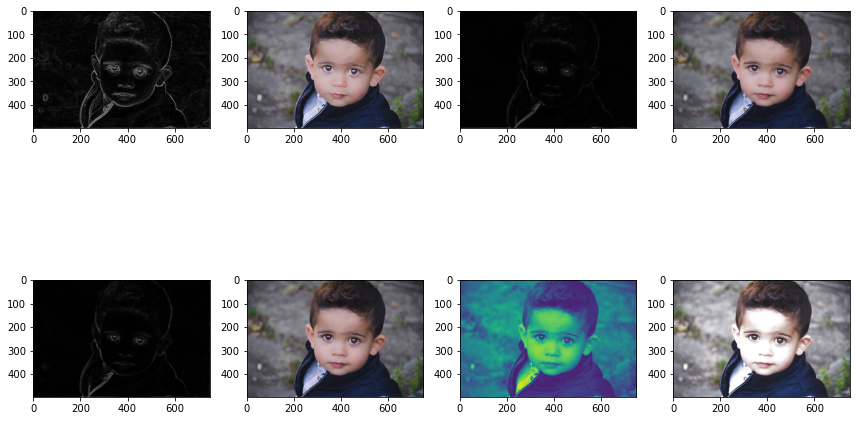

In [184]:
fig,ax=plt.subplots(nrows=2, ncols=4,figsize=(12,12))

test1 = np.copy(hlsImg).astype('int')
sobel_fil_ver_3 = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
sobel_fil_hor_3 = sobel_fil_ver_3.T
sobel_ver_fil_img = img_filter(sobel_fil_ver_3,test1[:,:,1])
sobel_hor_fil_img = img_filter(sobel_fil_hor_3,test1[:,:,1])
merge = 0.5*abs(sobel_ver_fil_img) + 0.5*abs(sobel_hor_fil_img)
test1[:,:,1] = test1[:,:,1] + 0.5 * merge
test1[:,:,1][test1[:,:,1]>255]=255
test1 = test1.astype('uint8')
Img1 = cv2.cvtColor(test1, cv2.COLOR_HLS2RGB)
ax[0,0].imshow(merge,cmap='gray')
ax[0,1].imshow(Img1)

test2 = np.copy(hlsImg).astype('int')
lap_fil_3=np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
fil_img = img_filter(lap_fil_3,test2[:,:,1])
test2[:,:,1] = test2[:,:,1] + 0.5 * fil_img
test2[:,:,1][test2[:,:,1]>255]=255
test2 = test2.astype('uint8')
Img2 = cv2.cvtColor(test2, cv2.COLOR_HLS2RGB)
ax[0,2].imshow(fil_img,cmap='gray')
ax[0,3].imshow(Img2)

fig.tight_layout()
test3 = np.copy(hlsImg).astype('int')
original = np.fft.fft2(test3[:,:,1])
center = np.fft.fftshift(original)

gau_lowpass_fil = gaussion_lowpass(original.shape[0],original.shape[1],50)
gau_lowpass_fil = 1 - gau_lowpass_fil
gau_lowpass_fil_img=center*gau_lowpass_fil
gau_lowpass_iCenter = np.fft.ifftshift(gau_lowpass_fil_img)
gau_lowpass_iOriginal = np.fft.ifft2(gau_lowpass_iCenter)
gau_lowpass_imgBack = np.abs(gau_lowpass_iOriginal)
test3[:,:,1] = test3[:,:,1] + 0.5 * gau_lowpass_imgBack
test3[:,:,1][test3[:,:,1]>255]=255
test3 = test3.astype('uint8')
Img3 = cv2.cvtColor(test3, cv2.COLOR_HLS2RGB)
ax[1,0].imshow(gau_lowpass_imgBack,cmap='gray')
ax[1,1].imshow(Img3)

test4 = np.copy(hlsImg).astype('int')
original = np.fft.fft2(test4[:,:,1])
center = np.fft.fftshift(original)

butter_fil = butterworth_lowpass(original.shape[0],original.shape[1],45,1)
butter_fil = 1 - butter_fil
butter_fil_img=center*butter_fil
butter_iCenter = np.fft.ifftshift(butter_fil_img)
butter_iOriginal = np.fft.ifft2(butter_iCenter)
butter_imgBack = np.abs(butter_iOriginal)
test4[:,:,1] = test4[:,:,1] + 0.5 * butter_imgBack
test4[:,:,1][test4[:,:,1]>255]=255
test4 = test4.astype('uint8')
Img4 = cv2.cvtColor(test4, cv2.COLOR_HLS2RGB)
ax[1,2].imshow(butter_imgBack)
ax[1,3].imshow(Img4)
fig.tight_layout()
plt.show()

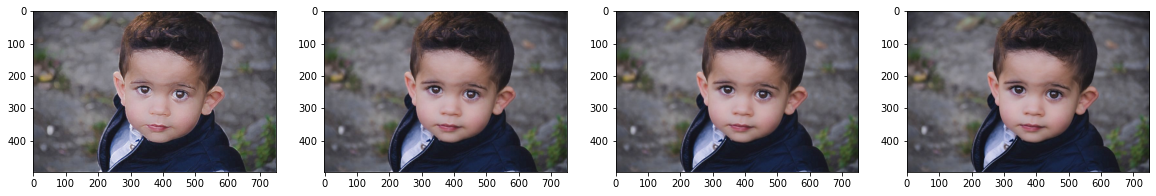

In [185]:
fig,ax=plt.subplots(nrows=1, ncols=4,figsize=(20,20))
ax[0].imshow(Img1)
ax[1].imshow(Img2)
ax[2].imshow(Img3)
ax[3].imshow(img)
plt.show()

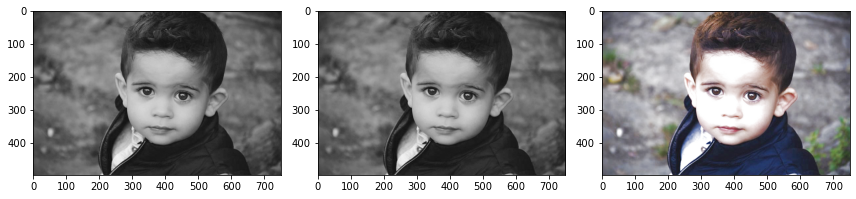

In [183]:
fig,ax=plt.subplots(nrows=1, ncols=3,figsize=(12,12))
test4 = np.copy(hlsImg).astype('int')
original = np.fft.fft2(test4[:,:,1])
center = np.fft.fftshift(original)

butter_fil = butterworth_lowpass(original.shape[0],original.shape[1],15,1)
butter_fil = 1 - butter_fil
butter_fil_img=center*butter_fil
butter_iCenter = np.fft.ifftshift(butter_fil_img)
butter_iOriginal = np.fft.ifft2(butter_iCenter)
butter_imgBack = np.abs(butter_iOriginal)
test4[:,:,1] = test4[:,:,1] + 0.5 * butter_imgBack
test4[:,:,1][test4[:,:,1]>255]=255
test4 = test4.astype('uint8')
Img4 = cv2.cvtColor(test4, cv2.COLOR_HLS2RGB)
ax[0].imshow(hlsImg[:,:,1],cmap='gray')
ax[1].imshow(butter_imgBack,cmap='gray')
ax[2].imshow(Img4)
fig.tight_layout()
plt.show()

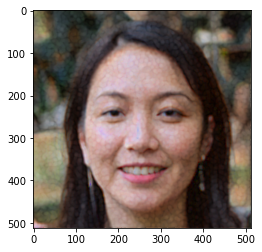

In [142]:
re = np.copy(gau_deb)
re[:,:,1] = re[:,:,1] + 0.4*merge
re_Img = cv2.cvtColor(re, cv2.COLOR_HLS2RGB)
plt.imshow(re_Img)
plt.show()